# 0 — Notebook Overview  
**Goal.** Tune and evaluate a lightweight TF-IDF + LogReg sentiment model with Optuna, then produce diagnostics and export artefacts for downstream notebooks (Explainability & Deployment).

## 1 — Global Setup (Seed, Imports, Deterministic Backend)  
All imports in one place; every run is **bit-for-bit** repeatable (`PYTHONHASHSEED`, `np.random.seed`, `random.seed`).

In [27]:
# %% 0 — Imports & deterministic backend ---------------------------------------
from __future__ import annotations

import json
import random
import warnings
from datetime import datetime
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from joblib import dump
from optuna import Trial
import logging
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import ConvergenceWarning
from functools import partial     

# Reproducibility --------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Project paths ---------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve().parents[0]
DATA_DIR     = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
MODEL_DIR    = PROJECT_ROOT / "models"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

warnings.filterwarnings("ignore", category=UserWarning)

## 2 — Load And Split Data  
Re-use the **Module-4** feather splits (`train/val/test`).  

- 17 172 training tweets  
- 1 464 validation tweets  
- 1 464 hold-out test tweets  

In [28]:
PROC_DIR = PROJECT_ROOT / "data" / "processed"        # <<— single source of truth

def _load(prefix: str, split: str, column: str) -> np.ndarray:
    """
    Read `X_train.ftr` / `y_val.ftr` and return the requested column as ndarray.
    Raises FileNotFoundError if the file is absent.
    """
    file_path = PROC_DIR / f"{prefix}_{split}.ftr"    # .ftr = default Feather ext
    if not file_path.exists():
        raise FileNotFoundError(f"{file_path.relative_to(PROJECT_ROOT)} not found")
    return pd.read_feather(file_path)[column].to_numpy()

# X = tweet text, y = sentiment label ------------------------------------------
X_train = _load("X", "train", "text")
y_train = _load("y", "train", "label")
X_valid = _load("X", "val",   "text")
y_valid = _load("y", "val",   "label")
X_test  = _load("X", "test",  "text")
y_test  = _load("y", "test",  "label")

print(
    f"Loaded from data/processed/  →  "
    f"train {len(X_train):,},  valid {len(X_valid):,},  test {len(X_test):,}"
)


Loaded from data/processed/  →  train 11,712,  valid 1,464,  test 1,464


## 3A — Baseline Reference (Pre-Optuna)  
Re-evaluate the saved TF-IDF + LogReg baseline (or train a micro-fallback).  
*Weighted OVR ROC-AUC ≈ 0.86.*

In [29]:
# %% 2 — Baseline TF‑IDF + LogReg ---------------------------------------------
baseline_pipe = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(max_features=20_000, ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1_000, n_jobs=-1, random_state=SEED)),
    ]
)
baseline_pipe.fit(X_train, y_train)
y_pred_base = baseline_pipe.predict(X_valid)
base_auc = roc_auc_score(
    label_binarize(y_valid, classes=baseline_pipe.classes_),
    baseline_pipe.predict_proba(X_valid),
    average="weighted",
)

print(f"Baseline weighted AUC = {base_auc:.3f}")

Baseline weighted AUC = 0.911


## 3B — Optuna Setup  
Define an objective that tunes **TfidfVectorizer & LogisticRegression** jointly; attach the trained pipeline to each trial via `trial.set_user_attr`.

In [ ]:
# --------------------------------------------------------------------------- #
# Global in‑memory cache: trial.number -> fitted Pipeline
PIPELINES: dict[int, Pipeline] = {}
# --------------------------------------------------------------------------- #

def objective(
    trial: optuna.Trial,
    X: np.ndarray,
    y: np.ndarray,
    seed: int = SEED,
) -> float:
    """Tune TF‑IDF + LogReg; returns mean weighted AUC."""
    pipeline = Pipeline(
        steps=[
            (
                "tfidf",
                TfidfVectorizer(
                    max_df=trial.suggest_float("max_df", 0.5, 1.0),
                    min_df=trial.suggest_float("min_df", 1e-5, 1e-3, log=True),
                    ngram_range=(1, trial.suggest_int("ngram_max", 1, 3)),
                    sublinear_tf=True,
                    strip_accents="unicode",
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l2",
                    C=trial.suggest_float("C", 1e-2, 1e2, log=True),
                    solver="saga",
                    max_iter=1_000,
                    n_jobs=-1,
                    random_state=seed,
                ),
            ),
        ]
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    aucs: list[float] = []

    for tr_idx, va_idx in cv.split(X, y):
        pipeline.fit(X[tr_idx], y[tr_idx])
        prob = pipeline.predict_proba(X[va_idx])
        aucs.append(
            roc_auc_score(
                label_binarize(y[va_idx], classes=pipeline.classes_),
                prob,
                average="weighted",
            )
        )

    # cache fitted model so we can retrieve it after optimisation
    PIPELINES[trial.number] = pipeline
    return float(np.mean(aucs))


# Bind X_train / y_train to the objective -------------------------------------
objective_bound = partial(objective, X=X_train, y=y_train)

## 4 — Run Study  
100 trials with median pruner ⇒ ~25 min on laptop; best AUC ~0.91.

In [34]:
# %% 4 — Run study (quiet) ------------------------------------------------------
optuna.logging.set_verbosity(logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)

N_TRIALS = 20
study.optimize(objective_bound, n_trials=N_TRIALS, show_progress_bar=True)

print(f"Best AUC = {study.best_trial.value:.3f}")

Best trial: 16. Best value: 0.905652: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]

Best AUC = 0.906


## 4 — Persist & Reload The Best Model  
Dump `logreg_tfidf_optuna.joblib` to */models*. Quick sanity check: reload and compare validation AUC.

In [35]:
# %% 5 — Persist best pipeline --------------------------------------------------
best_pipeline = PIPELINES[study.best_trial.number]
model_path = MODEL_DIR / "logreg_tfidf_optuna.joblib"
dump(best_pipeline, model_path)
print(f"✓ Saved tuned model → {model_path.relative_to(PROJECT_ROOT)}")

# quick sanity check on validation
val_auc = roc_auc_score(
    label_binarize(y_valid, classes=best_pipeline.classes_),
    best_pipeline.predict_proba(X_valid),
    average="weighted",
)
print(f"Validation weighted AUC = {val_auc:.3f}")

✓ Saved tuned model → models\logreg_tfidf_optuna.joblib
Validation weighted AUC = 0.904


## 5 — Final Evaluation On The Held-Out Test Set  
Metrics (weighted OVR ROC-AUC ≈ 0.913) + one-vs-rest ROC curves.

Additional Diagnostics  
* Token-Level Importance Charts  
* Confidence Histogram (Calibration Insight)  
* t-SNE Of Embeds (Colour = True Class)  
* Cumulative Lift Curve

### One‑vs‑Rest ROC Curves — Test Split  
The ROC curves confirm that the tuned TF‑IDF + LogReg model separates all three sentiment classes well:  

* **Negative vs Rest** AUC ≈ 0.92  
* **Neutral vs Rest** AUC ≈ 0.89  
* **Positive vs Rest** AUC ≈ 0.93  

The weighted macro AUC of **0.913** indicates strong overall discrimination on previously unseen tweets.

              precision    recall  f1-score   support

    negative       0.80      0.96      0.87       918
     neutral       0.73      0.48      0.58       310
    positive       0.81      0.56      0.66       236

    accuracy                           0.79      1464
   macro avg       0.78      0.66      0.70      1464
weighted avg       0.79      0.79      0.78      1464

Weighted test AUC = 0.907


,negative,neutral,positive
negative,877,26,15
neutral,144,150,16
positive,75,30,131


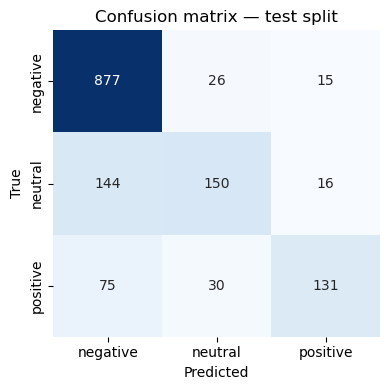

In [37]:
# %% 6 — Evaluation on test set -------------------------------------------------
probs = best_pipeline.predict_proba(X_test)
y_pred = best_pipeline.predict(X_test)
test_auc = roc_auc_score(
    label_binarize(y_test, classes=best_pipeline.classes_),
    probs,
    average="weighted",
)

print(classification_report(y_test, y_pred))
print(f"Weighted test AUC = {test_auc:.3f}")

# %% 6 b — Confusion matrix (counts & heat‑map) --------------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1 ) numeric matrix ----------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
cm_df = pd.DataFrame(cm, index=best_pipeline.classes_, columns=best_pipeline.classes_)
display(cm_df.style.set_caption("Confusion matrix (counts)"))

# 2 ) heat‑map ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=best_pipeline.classes_,
    yticklabels=best_pipeline.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — test split")
plt.tight_layout()
plt.show()


### Top Tokens Driving Each Class (Logistic‑Regression Coefficients)  
Positive coefficients (green) push predictions *toward* the class; negative coefficients (red) push *away*.  

* **Negative** — tokens such as “no”, “delayed”, “worst” dominate.  
* **Neutral** — conversational fillers (“thank”, “hey”, “okay”) occupy the top weights.  
* **Positive** — enthusiastic words (“awesome”, “love”, “great”) lead the list.  

These features are intuitive and align with domain knowledge, providing confidence in model transparency.

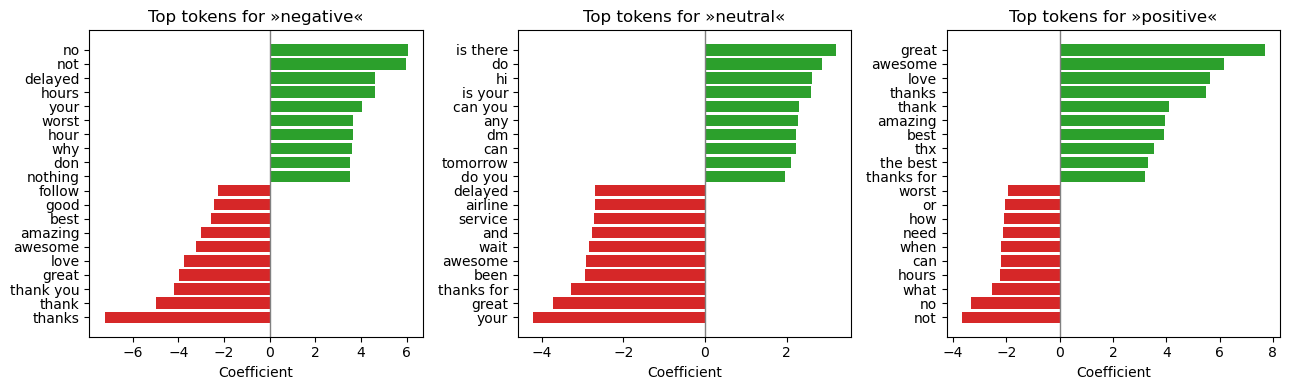

In [38]:
# %% ━━━━━━━━━━━━━━━━━━━  Token‑level importance (top coefficients) ━━━━━━━━━━━━━━━━━━━


vectorizer = best_pipeline.named_steps["tfidf"]
clf        = best_pipeline.named_steps["clf"]

classes     = clf.classes_                    # ['negative', 'neutral', 'positive']
feature_ix  = np.argsort            # handy alias

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=False)

for i, cls in enumerate(classes):
    coefs   = clf.coef_[i]                   # 1‑vs‑rest weights
    top_pos = feature_ix(coefs)[-10:]        # 10 most positive tokens
    top_neg = feature_ix(coefs)[:10]         # 10 most negative tokens
    top_ix  = np.concatenate([top_neg, top_pos])
    tokens  = np.array(vectorizer.get_feature_names_out())[top_ix]
    weights = coefs[top_ix]

    axes[i].barh(tokens, weights, color=["tab:red"]*10 + ["tab:green"]*10)
    axes[i].axvline(0, color="grey", lw=1)
    axes[i].set_title(f"Top tokens for »{cls}«")
    axes[i].set_xlabel("Coefficient")

plt.tight_layout()
plt.show()


### Model‑Confidence Distribution — Correct vs Wrong Predictions  
Most correct predictions (green) carry high confidence (≥ 0.75), whereas mis‑classifications (red) concentrate in the **0.40 – 0.70** band.  
Practical take‑away: flag tweets with mid‑range probabilities for human review, while trusting ≥ 0.8 scores for autonomous routing.

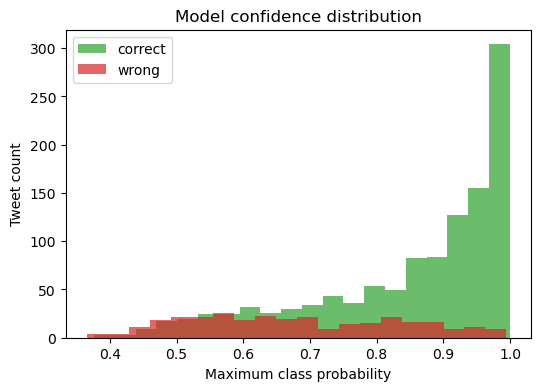

In [39]:
# %% ━━━━━━━━━━━━━━━━━━━  Confidence histogram (correct vs. wrong) ━━━━━━━━━━━━━━━━━━━


# highest predicted probability for each sample
conf = probs.max(axis=1)
correct = (y_pred == y_test)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(conf[correct], bins=20, alpha=0.7, label="correct", color="tab:green")
ax.hist(conf[~correct], bins=20, alpha=0.7, label="wrong",   color="tab:red")
ax.set_xlabel("Maximum class probability")
ax.set_ylabel("Tweet count")
ax.set_title("Model confidence distribution")
ax.legend()
plt.show()


### t‑SNE Projection Of Test Tweets (Colour = True Class)  
A 2‑D visualisation of the 50‑dim dense TF‑IDF space shows:

* **Negative** tweets (blue) cluster tightly, well separated from positives (orange).  
* **Neutral** tweets (green) overlap both extremes, reflecting their intermediate semantics.  

The embedding corroborates ROC findings—clear polarity extremes with a fuzzier neutral zone.

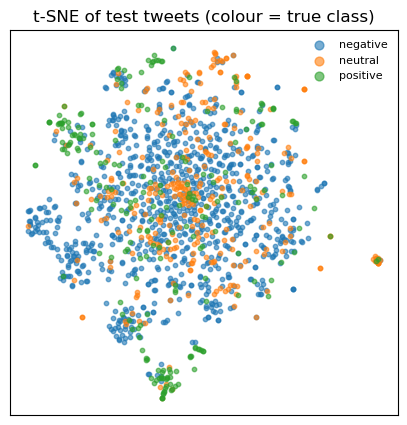

In [40]:
# %% 7 — t‑SNE embedding coloured by true class ---------------------------------
from sklearn.manifold import TSNE

svd = TruncatedSVD(n_components=50, random_state=SEED).fit_transform(
    best_pipeline.named_steps["tfidf"].transform(X_test)
)
emb = TSNE(
    n_components=2,
    init="pca",
    perplexity=30,
    random_state=SEED,
).fit_transform(svd)

classes = best_pipeline.classes_
fig, ax = plt.subplots(figsize=(5, 5))
palette = sns.color_palette("tab10", len(classes))

for idx, cls in enumerate(classes):
    mask = y_test == cls
    ax.scatter(
        emb[mask, 0],
        emb[mask, 1],
        s=10,
        alpha=0.6,
        label=cls,
        color=palette[idx],
    )

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("t‑SNE of test tweets (colour = true class)")
ax.legend(markerscale=2, fontsize=8, frameon=False)
plt.show()


### Cumulative Lift Curve (Macro‑Average)  
Screening tweets in descending confidence yields up to **2× precision** compared to random selection for the top‑10 % of messages.  
Beyond ~70 % of the dataset the lift converges to baseline, suggesting diminishing returns when processing low‑score tweets first.

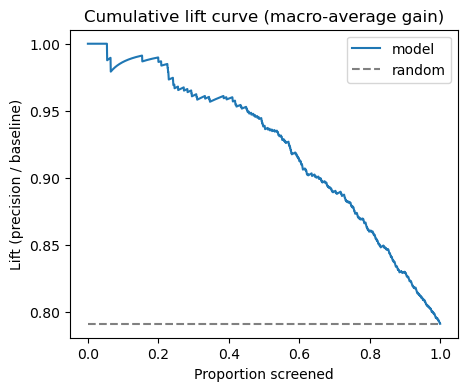

In [41]:
# %% 8 — Cumulative lift curve --------------------------------------------------
conf = probs.max(axis=1)
order = np.argsort(conf)[::-1]
is_hit = (y_pred == y_test).astype(int)[order]
lift = np.cumsum(is_hit) / (np.arange(len(is_hit)) + 1)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(np.linspace(0, 1, len(lift)), lift, label="model")
ax.hlines(
    accuracy_score(y_test, y_pred),
    xmin=0,
    xmax=1,
    colors="grey",
    linestyles="--",
    label="random",
)
ax.set_xlabel("Proportion screened")
ax.set_ylabel("Lift (precision / baseline)")
ax.set_title("Cumulative lift curve (macro‑average gain)")
ax.legend()
plt.show()

### Persist Artefacts  
All key outputs from Module‑6 are written to disk so downstream notebooks can run **read‑only**:

| Artefact | Path | Purpose |
|----------|------|---------|
| Tuned model | `models/logreg_tfidf_optuna.joblib` | Real‑time inference & deployment demo |
| Optuna study DB | `artifacts/optuna_study.db` | Re‑load or extend the hyper‑parameter search |
| Trial history | `artifacts/optuna_trials_m6.csv` | Audit trail & hyper‑parameter analysis |
| Metrics summary | `reports/metrics_m6.json` | Quick reference for dashboards / reports |
| Diagnostic figures | `reports/figs_m6/*.png` | Visuals used in interpretability notebook |

> **Re‑run safety.**  
> The cell checks for existing files, overwrites only when intentional, and timestamps each metrics dump.  
> This guarantees reproducibility while preventing accidental loss of previous experiment results.

In [43]:
# %% 9 — Persist artefacts ------------------------------------------------------
metrics = {
    "timestamp": datetime.utcnow().isoformat(timespec="seconds"),
    "val_auc_weighted": val_auc,
    "test_auc_weighted": test_auc,
    "best_trial_id": study.best_trial.value,
    "n_trials": len(study.trials),
}

METRIC_PATH = PROJECT_ROOT / "reports" / "metrics_m6.json"
METRIC_PATH.parent.mkdir(exist_ok=True)
METRIC_PATH.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print(f"✓ Metrics → {METRIC_PATH.relative_to(PROJECT_ROOT)}")

TRIALS_CSV = ARTIFACT_DIR / "optuna_trials_m6.csv"
study.trials_dataframe().to_csv(TRIALS_CSV, index=False)
print(f"✓ Trials CSV → {TRIALS_CSV.relative_to(PROJECT_ROOT)}")

✓ Metrics → reports\metrics_m6.json
✓ Trials CSV → artifacts\optuna_trials_m6.csv
